In [1]:
try:
    import fqe
except:
    !pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet 

In [2]:
import numpy as np
from scipy import sparse
from scipy.linalg import expm

import openfermion as of
import fqe

import matplotlib.pyplot as plt
try:
    plt.style.use('publish')
except:
    pass

In [36]:
import copy

In [42]:
from fqe.algorithm.low_rank import evolve_fqe_givens, evolve_fqe_charge_charge_alpha_beta
from fqe.algorithm.low_rank import evolve_fqe_givens_sector

In [3]:
class model(dict):
    
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError as e:
            raise AttributeError(name) from e
    
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
params = model(nsites=4, U = 2.0, t = 1.0)

hubbard = of.fermi_hubbard(1, params.nsites,
                           tunneling=params.t,
                           coulomb=params.U,
                           periodic=False)

In [5]:
nelectrons, Sz = 2, 0;

init_wavefunction = fqe.Wavefunction([[nelectrons,
                                       Sz, 
                                       params.nsites]])
init_wavefunction.set_wfn(strategy='random')

In [13]:
%%time
evolve_time = 1.0;
true_evolved_fqe = init_wavefunction.time_evolve(evolve_time, hubbard);

CPU times: user 21.4 ms, sys: 2.8 ms, total: 24.2 ms
Wall time: 23.7 ms


In [14]:
%%time

init_cirq_wfn=fqe.to_cirq(init_wavefunction)
# U = expm(-i*t*H)
H_matrix = of.get_sparse_operator(hubbard).todense()
unitary = expm(-1j*evolve_time*H_matrix)

true_evolved_cirq = unitary@init_cirq_wfn

CPU times: user 132 ms, sys: 10.5 ms, total: 142 ms
Wall time: 109 ms


In [16]:
fidelty=abs(fqe.vdot(true_evolved_fqe,
            fqe.from_cirq(true_evolved_cirq,
                         thresh=1e-12)))**2
print('F-1  = ', abs(fidelty-1.0))

F-1  =  4.440892098500626e-16


In [23]:
nqubits = 2*params.nsites

one_body = [ op + of.hermitian_conjugated(op)
            for op in (of.FermionOperator(((i,1), (i+2,0)), 
                      coefficient= -1*params.t) for i in range(nqubits-2))]
two_body = [of.FermionOperator(((i,1),(i,0), (i+1,1),(i+1,0)), coefficient=params.U)
            for i in range(0, nqubits, 2)]

In [25]:
hopping_matrix = of.get_sparse_operator(sum(one_body))
unitary = expm(-1j*evolve_time*hopping_matrix.todense())
evolved_cirq_wfn = unitary @ init_cirq_wfn

In [27]:
hopping_matrix = -params.t*(np.diag([1]*(params.nsites-1), k=1)
                            +np.diag([1]*(params.nsites-1), k=-1))

In [28]:
umat = expm(-1j*evolve_time*hopping_matrix)
evolved_wavefunction=evolve_fqe_givens(init_wavefunction, umat)

In [30]:
fidelity=abs(fqe.vdot(evolved_wavefunction, 
             fqe.from_cirq(evolved_cirq_wfn,thresh=1e-6)))**2
print('F-1 = ', abs(fidelity-1))

F-1 =  0.0


In [31]:
coulomb_matrix=of.get_sparse_operator(sum(two_body))
unitary=expm(-1j*evolve_time*coulomb_matrix.todense())
evolved_cirq_wfn=unitary@init_cirq_wfn

In [32]:
coulomb_matrix=np.diag([params.U]*params.nsites)

In [34]:
evolved_fqe_wfn=evolve_fqe_charge_charge_alpha_beta(init_wavefunction,
                                                   coulomb_matrix,
                                                   evolve_time)

In [35]:
fidelity = abs(fqe.vdot(evolved_fqe_wfn, fqe.from_cirq(evolved_cirq_wfn, thresh=1e-6)))**2
print('F-1 = ', abs(fidelty-1))

F-1 =  4.440892098500626e-16


In [37]:
steps=10
umat = expm(-1j*hopping_matrix*(evolve_time/steps))

current_wfn=copy.deepcopy(init_wavefunction)
for st in range(steps):
    
    current_wfn=evolve_fqe_givens(current_wfn, u=umat)
    
    current_wfn=evolve_fqe_charge_charge_alpha_beta(
                current_wfn,
                coulomb_matrix,
                evolve_time/steps
    )

In [38]:
trotterized_fidelity = abs(fqe.vdot(true_evolved_fqe, current_wfn))**2
print(trotterized_fidelity)

0.9988722601807759


In [68]:
params = model(nsites   = 8,
               l_up     = 4,
               m_up     = 4.5,
               sigma_up = 1,
               U = 3.0
              )

site_index = np.arange(1, params.nsites+1)

Hσ_up = np.diag([-1.]*(params.nsites-1), k=1)+np.diag([-1.] *(params.nsites - 1), k=-1)
Hσ_up += np.diag(-params.l_up*np.exp(-0.5*(site_index-params.m_up)**2)/params.sigma_up**2)
Hσ_dn = np.diag([-1.]*(params.nsites-1), k=1)+np.diag([-1.] *(params.nsites - 1), k=-1)               

In [69]:
init_wfn = fqe.Wavefunction([[params.nsites//2, 0, params.nsites]])
init_wfn.set_wfn(strategy='hartree-fock')
init_wfn.print_wfn()

Sector N = 4 : S_z = 0
a'00000011'b'00000011' (1+0j)


In [70]:
# find the eigenbasis
vup = np.linalg.eigh(Hσ_up)[1]
vdn = np.linalg.eigh(Hσ_dn)[1]

In [71]:
init_wfn = evolve_fqe_givens_sector(init_wfn, vup, sector='alpha')
init_wfn = evolve_fqe_givens_sector(init_wfn, vdn, sector='beta')

In [94]:
opdm_a, opdm_b = init_wfn.sector((params.nsites // 2, 0)).get_spin_opdm()

dt = 0.3
steps = 55
hopping_u = expm(-1j*dt*Hσ_dn)
charge_u  = np.diag([params.U]*params.nsites)
opdms_alpha=[opdm_a]
opdms_beta=[opdm_b]
times=[0.0]
current_time = 0.0
final_wfn = init_wfn
for t in range(steps):
    final_wfn=evolve_fqe_givens(final_wfn, hopping_u)
    final_wfn=evolve_fqe_charge_charge_alpha_beta(final_wfn, charge_u, dt)
    current_time += dt
    
    opdm_a_current, opdm_b_current = final_wfn.sector((params.nsites//2,0)).get_spin_opdm()
    opdms_alpha.append(opdm_a_current)
    opdms_beta.append(opdm_b_current)
    times.append(current_time)

In [116]:
select_times=[0.0, 1.2, 1.8, 3.]
time_indices=[int(t/dt) for t in select_times]

charge = [np.diagonal(opdms_alpha[idx]+opdms_beta[idx]).real
    for idx in time_indices]
spin = [np.diagonal(opdms_alpha[idx]-opdms_beta[idx]).real
    for idx in time_indices]

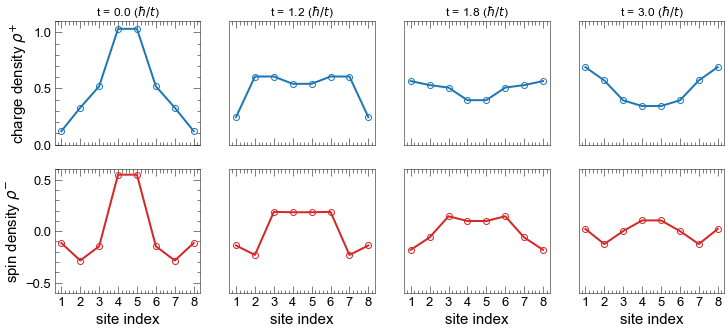

In [138]:
fig,ax = plt.subplots(2,len(select_times), sharex=True, figsize=(12, 5))

for i,c,s in zip(range(len(select_times)), charge, spin):
    
    ax[0,i].plot(site_index, c, 'o-', mfc='none', color='tab:blue')
    ax[1,i].plot(site_index, s, 'o-', mfc='none', color='tab:red')
    ax[0,i].set_ylim(0, 1.1)
    ax[1,i].set_ylim(-0.6, 0.6)
    ax[1,i].set_xticks(site_index)
    ax[1,i].set_xlabel('site index')
    if i != 0: ax[0, i].set_yticks([]);
    if i != 0: ax[1, i].set_yticks([]);
    ax[0,i].set_title(r't = {:1.1f} ($\hbar/t$)'.format(select_times[i]))
ax[0,0].set_ylabel(r'charge density $\rho^{+}$')
ax[1,0].set_ylabel(r'spin density $\rho^{-}$')

plt.savefig('snapshot.pdf')

In [150]:
nup_all_time = np.array([np.diagonal(alpha).real for (alpha, beta) in zip(opdms_alpha, opdms_beta)])
ndn_all_time = np.array([np.diagonal(beta).real for (alpha, beta) in zip(opdms_alpha, opdms_beta)])
#spin_all_time =  np.array([np.diagonal(alpha-beta).real for (alpha, beta) in zip(opdms_alpha, opdms_beta)])

In [153]:
nup_all_time

array([[0.002055  , 0.02196527, 0.18623579, 0.78974394, 0.78974394,
        0.18623579, 0.02196527, 0.002055  ],
       [0.00223427, 0.02967753, 0.24682716, 0.72126104, 0.72126104,
        0.24682716, 0.02967753, 0.00223427],
       [0.00524075, 0.06088448, 0.34364209, 0.59023269, 0.59023269,
        0.34364209, 0.06088448, 0.00524075],
       [0.01840544, 0.12211441, 0.39455177, 0.46492837, 0.46492837,
        0.39455177, 0.12211441, 0.01840544],
       [0.05298825, 0.18757967, 0.39686223, 0.36256986, 0.36256986,
        0.39686223, 0.18757967, 0.05298825],
       [0.114017  , 0.22367181, 0.37639258, 0.28591861, 0.28591861,
        0.37639258, 0.22367181, 0.114017  ],
       [0.19230246, 0.2344619 , 0.32605593, 0.24717971, 0.24717971,
        0.32605593, 0.2344619 , 0.19230246],
       [0.26898591, 0.2363266 , 0.25235402, 0.24233347, 0.24233347,
        0.25235402, 0.2363266 , 0.26898591],
       [0.32883715, 0.22461168, 0.20179626, 0.24475491, 0.24475491,
        0.20179626, 0.224611

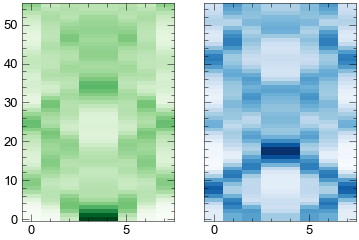

In [152]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].imshow(nup_all_time, cmap='Greens', aspect='auto', origin='lower')
ax[1].imshow(ndn_all_time, cmap='Blues', aspect='auto', origin='lower')

In [99]:

spread= np.abs(np.arange(1, params.nsites+1)-(params.nsites+1)/2)
charge_spread=[np.multiply(spread,np.diagonal(alpha+beta).real).sum() 
               for (alpha,beta) in zip(opdms_alpha, opdms_beta)]
spin_spread=[np.multiply(spread,np.diagonal(alpha-beta).real).sum() 
               for (alpha, beta) in zip(opdms_alpha, opdms_beta)]

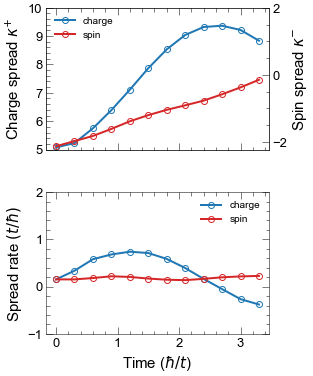

In [137]:
fig,ax=plt.subplots(2,1, sharex=True, figsize=(4,6))
stop=12
ax[0].plot(times[:stop], charge_spread[:stop], 'o-', mfc='none', color='tab:blue', label='charge')
ax2=ax[0].twinx()
ax[0].set_ylim(5, 10)
ax[0].plot(times[:stop], spin_spread[:stop], 'o-', mfc='none', color='tab:red', label='spin')
#ax[1].set_xticks(list(range(0, 3, 1)))
ax2.plot(times[:stop], spin_spread[:stop], 'o-', mfc='none', color='tab:red', label='spin')
#ax[1].set_xticks(list(range(0, 3, 1)))
ax[-1].set_xlabel(r'Time ($\hbar/t$)')
ax[0].set_ylabel(r'Charge spread $\kappa^{+}$'); ax2.set_ylabel(r'Spin spread $\kappa^{-}$')
ax2.set_yticks([-2,0,2])
ax[1].plot(times[:stop], np.gradient(charge_spread[:stop]), 'o-', mfc='none', label='charge')
#ax2=ax[1].twinx()
ax[1].plot(times[:stop], np.gradient(spin_spread[:stop]), 'o-', mfc='none', color='tab:red', label='spin')
ax[1].set_ylabel(r'Spread rate $(t/\hbar)$')
plt.subplots_adjust(hspace=0.3)
ax[1].legend(); ax[0].legend()
ax[1].set_ylim(-1, 2)
plt.savefig('spread.pdf')